# 1. Data Collection

In [1]:
import pandas as pd
import numpy as np

# Load data
url = 'https://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
                "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
                "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
                "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                "dst_host_srv_rerror_rate","label"]

data = pd.read_csv(url, names=column_names)
data.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


#2. Preprocessing

Encoding categorical variables and normalizing numerical features.

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encoding categorical features
categorical_columns = ["protocol_type", "service", "flag"]
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Normalizing numerical features
numerical_columns = data.columns.difference(categorical_columns + ["label"])
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Droping the label column for unsupervised learning
data_unlabeled = data.drop(columns=["label"])


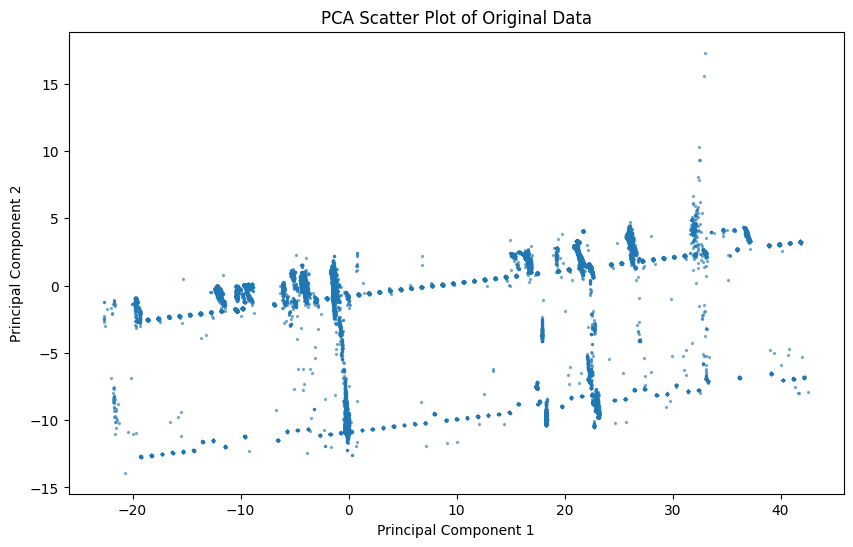

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Reduce dimensionality with PCA to 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_unlabeled)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, s=2)
plt.title('PCA Scatter Plot of Original Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# 3. Isolation Forest

Training the Isolation Forest model to detect anomalies.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies detected by Isolation Forest: 4930
Indices of anomalies detected by Isolation Forest: [  4026  11518  22580 ... 485183 486892 491413]


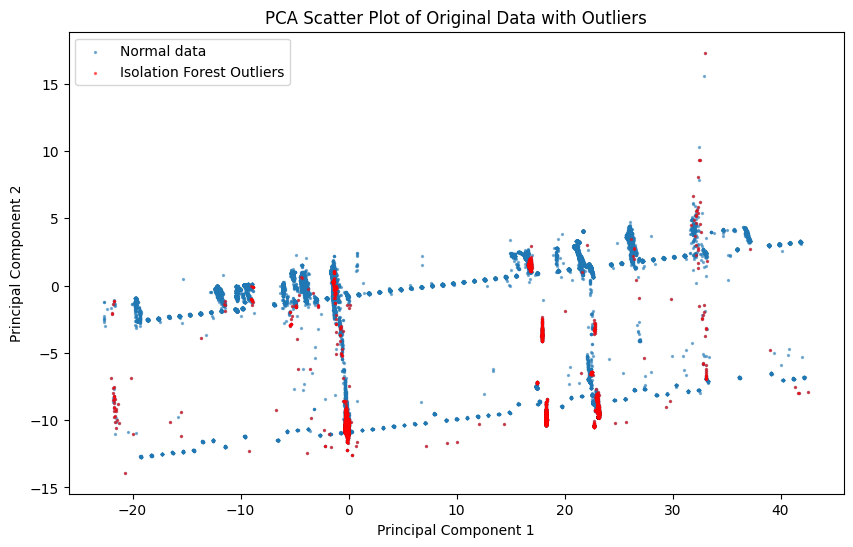

In [13]:
# Detecting outliers using Isolation Forest
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
isolation_forest.fit(data_unlabeled)
anomalies = isolation_forest.predict(data_unlabeled)
outlier_indices_if = np.where(anomalies == -1)[0]

anomaly_data = data_unlabeled[anomalies == -1] # -1 for anomalies, 1 for normal data
print(f"Number of anomalies detected by Isolation Forest: {len(anomaly_data)}")
print(f"Indices of anomalies detected by Isolation Forest: {outlier_indices_if}")
anomalies

# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_unlabeled)

plt.figure(figsize=(10, 6))
# Plot all points
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, s=2, label='Normal data')

# Plot Isolation Forest outliers
plt.scatter(data_pca[outlier_indices_if, 0], data_pca[outlier_indices_if, 1],
            color='red', alpha=0.5, s=2, label='Isolation Forest Outliers')

plt.title('PCA Scatter Plot of Original Data with Outliers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

#4. Autoencoder

Training the Autoencoder to detect anomalies.



In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Autoencoder model
input_dim = data_unlabeled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(encoder)
decoder = Dense(64, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Training the Autoencoder
autoencoder.fit(data_unlabeled, data_unlabeled, epochs=50, batch_size=256, validation_split=0.1, verbose=1)

# Predicting and calculate reconstruction errors
reconstructions = autoencoder.predict(data_unlabeled)
mse = np.mean(np.power(data_unlabeled - reconstructions, 2), axis=1)

# Setting threshold for anomalies
threshold = np.percentile(mse, 95)
anomaly_data_autoencoder = data_unlabeled[mse > threshold]
print(f"Number of anomalies detected by Autoencoder: {len(anomaly_data_autoencoder)}")


Epoch 1/50
1737/1737 [==============================] - 7s 3ms/step - loss: 16.9729 - val_loss: 34.1961
Epoch 2/50
1737/1737 [==============================] - 5s 3ms/step - loss: 16.9519 - val_loss: 34.2015
Epoch 3/50
1737/1737 [==============================] - 5s 3ms/step - loss: 16.9510 - val_loss: 34.2030
Epoch 4/50
1737/1737 [==============================] - 6s 4ms/step - loss: 16.9509 - val_loss: 34.1905
Epoch 5/50
1737/1737 [==============================] - 5s 3ms/step - loss: 16.9507 - val_loss: 34.1968
Epoch 6/50
1737/1737 [==============================] - 5s 3ms/step - loss: 16.9505 - val_loss: 34.1880
Epoch 7/50
1737/1737 [==============================] - 6s 4ms/step - loss: 16.9505 - val_loss: 34.1896
Epoch 8/50
1737/1737 [==============================] - 5s 3ms/step - loss: 16.9505 - val_loss: 34.1921
Epoch 9/50
1737/1737 [==============================] - 7s 4ms/step - loss: 16.9506 - val_loss: 34.1843
Epoch 10/50
1737/1737 [==============================] - 5s 3ms/

In [5]:
# Displaying the first few anomalies detected by Autoencoder
print("Anomalies detected by Autoencoder:")
print(anomaly_data_autoencoder.head())


Anomalies detected by Autoencoder:
     duration  protocol_type  service  flag  src_bytes  dst_bytes      land  \
206 -0.067792              1       50     9   0.000344  -0.016330 -0.006673   
207 -0.067792              1       50     9  -0.001376  -0.016360 -0.006673   
208 -0.067792              1       50     9  -0.002302  -0.017843 -0.006673   
210 -0.067792              1       50     9  -0.002434  -0.016330 -0.006673   
211 -0.067792              1       50     9  -0.002247  -0.016390 -0.006673   

     wrong_fragment    urgent       hot  ...  dst_host_count  \
206        -0.04772 -0.002571 -0.044136  ...       -3.466981   
207        -0.04772 -0.002571 -0.044136  ...       -3.312530   
208        -0.04772 -0.002571 -0.044136  ...       -3.158078   
210        -0.04772 -0.002571 -0.044136  ...       -2.849176   
211        -0.04772 -0.002571 -0.044136  ...       -2.694724   

     dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  \
206           -1.713175       

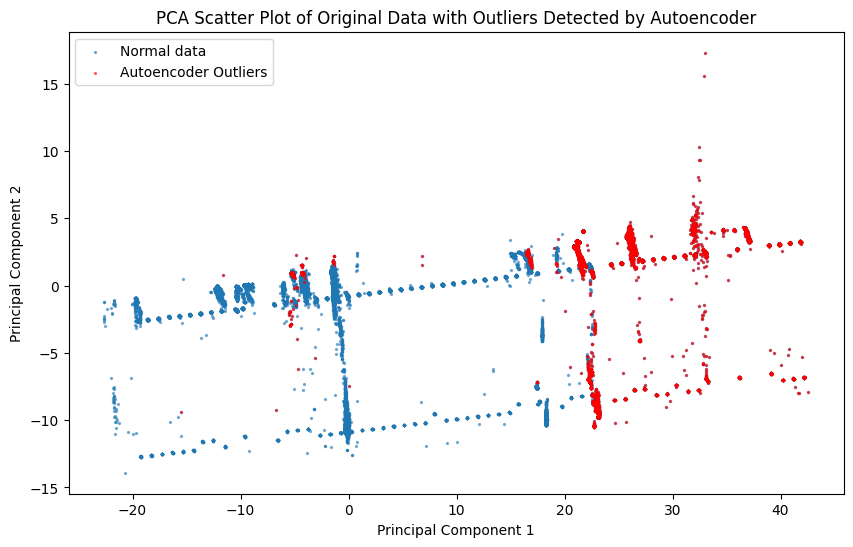

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_unlabeled)

# Get the indices of outliers detected by the Autoencoder
outlier_indices_autoencoder = np.where(mse > threshold)[0]

plt.figure(figsize=(10, 6))

# Plot all points
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, s=2, label='Normal data')

# Plot Autoencoder outliers in red
plt.scatter(data_pca[outlier_indices_autoencoder, 0], data_pca[outlier_indices_autoencoder, 1],
            color='red', alpha=0.5, s=2, label='Autoencoder Outliers')

plt.title('PCA Scatter Plot of Original Data with Outliers Detected by Autoencoder')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
